In [1]:
!pip install pandas numpy matplotlib scikit-learn scipy torch 

  Using cached pandas-2.2.3-cp312-cp312-macosx_11_0_arm64.whl.metadata (89 kB)
  Using cached numpy-2.2.5-cp312-cp312-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached matplotlib-3.10.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached scikit_learn-1.6.1-cp312-cp312-macosx_12_0_arm64.whl.metadata (31 kB)
  Using cached scipy-1.15.2-cp312-cp312-macosx_14_0_arm64.whl.metadata (61 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp312-cp312-macosx_10_13_universal2.whl.metadata (102 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.2 kB)
  Using cached pillow-11.2.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (8.9 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from itertools import product
from sklearn.utils import resample
from scipy.stats import beta as bt
import torch
import torch.optim as optim
import torch.nn as nn
from scipy.optimize import minimize
import math
import ast

# Parameter fitting

In [3]:
df = pd.read_csv("../data/regret_preregistered_1_for_sim.csv")
df.head()

,Unnamed: 0,workerid,trial_index,points,choice,choice_goodbad,condition,source,final_points,expected_value,total_expected_value
0,1,860,1,1,1,best,regret_late,data,31,0.7,35.4
1,2,860,2,1,1,best,regret_late,data,31,0.7,35.4
2,3,860,3,1,1,best,regret_late,data,31,0.7,35.4
3,4,860,4,1,1,best,regret_late,data,31,0.7,35.4
4,5,860,5,1,1,best,regret_late,data,31,0.7,35.4


In [4]:
df = df[
        ((df['condition'] == 'regret_early') & (df['trial_index'] <= 30)) | 
        ((df['condition'] == 'regret_late') & (df['trial_index'] > 30)) |
        (df['condition'] == 'control')]

df.head()


,Unnamed: 0,workerid,trial_index,points,choice,choice_goodbad,condition,source,final_points,expected_value,total_expected_value
30,31,860,31,1,1,best,regret_late,data,31,0.7,35.4
31,32,860,32,1,1,best,regret_late,data,31,0.7,35.4
32,33,860,33,0,1,best,regret_late,data,31,0.7,35.4
33,34,860,34,1,1,best,regret_late,data,31,0.7,35.4
34,35,860,35,1,0,medium,regret_late,data,31,0.5,35.4


## Grass-Is-Greener (GiG)

In [40]:
##################################################################
# 1) Log-Likelihood
##################################################################
def thompson_log_likelihood_for_omega(participant_df, condition, omega, eta, num_arms=3):
    if condition == "control":
        omega = 0.0

    ll = 0.0
    alpha_vals = [1.0] * num_arms
    beta_vals = [1.0] * num_arms

    df_sorted = participant_df.sort_values("trial_index")

    for _, row in df_sorted.iterrows():
        choice = int(row['choice'])
        points = int(row['points'])
        trial_idx = int(row['trial_index'])

        p_choice = prob_thompson_is_arm_max(choice, alpha_vals, beta_vals)
        p_choice_clamped = max(p_choice, 1e-12)
        ll += math.log(p_choice_clamped)

        if points == 1:
            alpha_vals[choice] += 1.0
        else:
            beta_vals[choice] += 1.0
            if condition == "regret_early" and trial_idx <= 30:
                for arm_i in range(num_arms):
                    if arm_i != choice:
                        alpha_vals[arm_i] += eta * omega
            elif condition == "regret_late" and trial_idx > 30:
                for arm_i in range(num_arms):
                    if arm_i != choice:
                        alpha_vals[arm_i] += eta * omega

    return ll

##################################################################
# 2) Helpers for Thompson Sampling
##################################################################
def beta_pdf(x, alpha, beta):
    c = math.exp(math.lgamma(alpha+beta) - math.lgamma(alpha) - math.lgamma(beta))
    return c * (x**(alpha-1.0)) * ((1.0-x)**(beta-1.0))

def beta_cdf(x, alpha, beta, steps=50):
    x_clamped = max(1e-8, min(x, 1-1e-8))
    dx = x_clamped / steps
    grid = [dx*(i+0.5) for i in range(steps)]
    return sum(beta_pdf(val, alpha, beta) for val in grid) * dx

def prob_thompson_is_arm_max(i, alphas, betas, resolution=50):
    alpha_i = alphas[i]
    beta_i = betas[i]
    dx = 1.0 / resolution
    xs = [dx*(k+0.5) for k in range(resolution)]

    sum_integral = 0.0
    for x in xs:
        f_i = beta_pdf(x, alpha_i, beta_i)
        if f_i <= 0:
            continue
        prod_cdfs = 1.0
        for j in range(len(alphas)):
            if j != i:
                prod_cdfs *= beta_cdf(x, alphas[j], betas[j], steps=20)
        sum_integral += f_i * prod_cdfs

    return sum_integral * dx

##################################################################
# 3) Priors
##################################################################
def log_prior_omega(omega):
    if omega < 0:
        return -float('inf')
    sigma = 2.0
    return -(omega**2) / (2.0 * sigma * sigma)

def log_prior_eta(eta):
    if eta < 0 or eta > 1:
        return -float('inf')
    return 0.0 

##################################################################
# 4) MCMC for omega and eta
##################################################################
def mcmc_fit_omega_eta_thompson(
    participant_df,
    condition,
    init_omega=0.5,
    init_eta=0.5,
    proposal_std_omega=0.1,
    proposal_std_eta=0.05,
    num_samples=2000,
    burn_in=500
):
    omega_current = init_omega
    eta_current = init_eta

    ll_current = thompson_log_likelihood_for_omega(participant_df, condition, omega_current, eta_current)
    lp_current = log_prior_omega(omega_current) + log_prior_eta(eta_current)

    chain = []

    for s in range(num_samples):
        log_omega_proposed = math.log(omega_current + 1e-8) + random.gauss(0, proposal_std_omega)
        omega_proposed = math.exp(log_omega_proposed)

        logit_eta_current = math.log((eta_current + 1e-8) / (1 - eta_current + 1e-8))
        logit_eta_proposed = logit_eta_current + random.gauss(0, proposal_std_eta)
        eta_proposed = 1.0 / (1.0 + math.exp(-logit_eta_proposed))

        ll_prop = thompson_log_likelihood_for_omega(participant_df, condition, omega_proposed, eta_proposed)
        lp_prop = log_prior_omega(omega_proposed) + log_prior_eta(eta_proposed)

        log_accept_ratio = (ll_prop + lp_prop) - (ll_current + lp_current)

        if math.log(random.random()) < log_accept_ratio:
            omega_current = omega_proposed
            eta_current = eta_proposed
            ll_current = ll_prop
            lp_current = lp_prop

        chain.append((omega_current, eta_current))

    return chain[burn_in:]

##################################################################
# 5) fit all participants
##################################################################
def run_mcmc_for_all_participants_thompson(df):
    unique_participants = df['workerid'].unique()

    results = []
    all_chains = {}

    for pid in unique_participants:
        p_df = df[df['workerid'] == pid]
        cond = p_df['condition'].iloc[0]

        random_init_omega = random.uniform(0.01, 1.0)
        random_init_eta = random.uniform(0.01, 0.99)

        chain = mcmc_fit_omega_eta_thompson(
            participant_df=p_df,
            condition=cond,
            init_omega=random_init_omega,
            init_eta=random_init_eta,
            proposal_std_omega=0.1,
            proposal_std_eta=0.05,
            num_samples=2000,
            burn_in=500
        )

        all_chains[pid] = chain
        omegas, etas = zip(*chain)

        mean_omega = torch.tensor(omegas).mean().item()
        median_omega = torch.tensor(omegas).median().item()
        mean_eta = torch.tensor(etas).mean().item()
        median_eta = torch.tensor(etas).median().item()

        print(f"Participant {pid} - Condition: {cond}, "
              f"Mean omega: {mean_omega:.4f}, Median omega: {median_omega:.4f}, "
              f"Mean eta: {mean_eta:.4f}, Median eta: {median_eta:.4f}")

        results.append({
            "participant": pid,
            "condition": cond,
            "mean_omega": mean_omega,
            "median_omega": median_omega,
            "mean_eta": mean_eta,
            "median_eta": median_eta
        })

    results_df = pd.DataFrame(results)
    return results_df, all_chains

results_df, posterior_chains = run_mcmc_for_all_participants_thompson(df)
print(results_df)

Participant 860 - Condition: regret_late, Mean omega: 1.4766, Median omega: 1.2013, Mean eta: 0.2737, Median eta: 0.2648
Participant 835 - Condition: regret_late, Mean omega: 0.0117, Median omega: 0.0071, Mean eta: 0.7112, Median eta: 0.6996
Participant 753 - Condition: regret_late, Mean omega: 0.0049, Median omega: 0.0042, Mean eta: 0.4614, Median eta: 0.4498
Participant 833 - Condition: regret_late, Mean omega: 0.8792, Median omega: 0.5519, Mean eta: 0.2105, Median eta: 0.2155
Participant 841 - Condition: regret_late, Mean omega: 0.0135, Median omega: 0.0071, Mean eta: 0.3111, Median eta: 0.2659
Participant 806 - Condition: regret_late, Mean omega: 1.4623, Median omega: 0.9487, Mean eta: 0.3925, Median eta: 0.3988
Participant 811 - Condition: regret_late, Mean omega: 0.1393, Median omega: 0.0205, Mean eta: 0.2200, Median eta: 0.2101
Participant 823 - Condition: regret_late, Mean omega: 0.0018, Median omega: 0.0008, Mean eta: 0.0658, Median eta: 0.0533
Participant 764 - Condition: reg

In [ ]:
# save the most recent results_df as csv
results_df.to_csv('../data/gig_mcmc_eta.csv', index=False)

In [32]:
print(results_df.groupby("condition")["mean_omega"].describe())
print(results_df.groupby("condition")["mean_eta"].describe())

              count      mean       std       min       25%       50%  \
condition                                                               
control        56.0  0.000000  0.000000  0.000000  0.000000  0.000000   
regret_early   60.0  0.752153  0.794723  0.000063  0.070086  0.391696   
regret_late    60.0  0.411632  0.815662  0.000263  0.009645  0.039773   

                   75%       max  
condition                         
control       0.000000  0.000000  
regret_early  1.458025  2.630495  
regret_late   0.288150  3.924921  
              count      mean       std       min       25%       50%  \
condition                                                               
control        56.0  0.500000  0.000000  0.500000  0.500000  0.500000   
regret_early   60.0  0.512520  0.312188  0.018301  0.247315  0.537640   
regret_late    60.0  0.461101  0.314380  0.006863  0.136989  0.468153   

                   75%       max  
condition                         
control       0.500000 

## Counterfactual Sampling (CS)

In [237]:
##################################################################
# 1) Log-Likelihood
##################################################################
def thompson_log_likelihood_for_omega(participant_df, condition, omega, eta, num_arms=3):
    if condition == "control":
        omega = 0.0

    ll = 0.0
    alpha_vals = [1.0] * num_arms
    beta_vals = [1.0] * num_arms

    df_sorted = participant_df.sort_values("trial_index")

    for _, row in df_sorted.iterrows():
        choice = int(row['choice'])
        points = int(row['points'])
        trial_idx = int(row['trial_index'])

        p_choice = prob_thompson_is_arm_max(choice, alpha_vals, beta_vals)
        p_choice_clamped = max(p_choice, 1e-12)
        ll += math.log(p_choice_clamped)

        if points == 1:                                   
            alpha_vals[choice] += 1.0
        else:                                               
            beta_vals[choice] += 1.0

            tree_beliefs = [
                a / (a + b) for a, b in zip(alpha_vals, beta_vals)
            ]                                               
            counterfactual_weight = eta * omega

            if condition == "regret_early" and trial_idx <= 30:
                for tree in range(num_arms):
                    if tree != choice:
                        cf_outcome = np.random.choice(
                            [0, 1],
                            p=[1 - tree_beliefs[tree], tree_beliefs[tree]]
                        )
                        if cf_outcome == 1:
                            alpha_vals[tree] += counterfactual_weight
                        else:
                            beta_vals[tree]  += counterfactual_weight

            elif condition == "regret_late" and trial_idx > 30:

                for tree in range(num_arms):
                    if tree != choice:
                        cf_outcome = np.random.choice(
                            [0, 1],
                            p=[1 - tree_beliefs[tree], tree_beliefs[tree]]
                        )
                        if cf_outcome == 1:
                            alpha_vals[tree] += counterfactual_weight
                        else:
                            beta_vals[tree]  += counterfactual_weight

    return ll

##################################################################
# 2) Helpers for Thompson Sampling
##################################################################
def beta_pdf(x, alpha, beta):
    c = math.exp(math.lgamma(alpha+beta) - math.lgamma(alpha) - math.lgamma(beta))
    return c * (x**(alpha-1.0)) * ((1.0-x)**(beta-1.0))

def beta_cdf(x, alpha, beta, steps=50):
    x_clamped = max(1e-8, min(x, 1-1e-8))
    dx = x_clamped / steps
    grid = [dx*(i+0.5) for i in range(steps)]
    return sum(beta_pdf(val, alpha, beta) for val in grid) * dx

def prob_thompson_is_arm_max(i, alphas, betas, resolution=50):
    alpha_i = alphas[i]
    beta_i = betas[i]
    dx = 1.0 / resolution
    xs = [dx*(k+0.5) for k in range(resolution)]

    sum_integral = 0.0
    for x in xs:
        f_i = beta_pdf(x, alpha_i, beta_i)
        if f_i <= 0:
            continue
        prod_cdfs = 1.0
        for j in range(len(alphas)):
            if j != i:
                prod_cdfs *= beta_cdf(x, alphas[j], betas[j], steps=20)
        sum_integral += f_i * prod_cdfs

    return sum_integral * dx

##################################################################
# 3) Priors
##################################################################
def log_prior_omega(omega):
    if omega < 0:
        return -float('inf')
    sigma = 2.0
    return -(omega**2) / (2.0 * sigma * sigma)

def log_prior_eta(eta):
    if eta < 0 or eta > 1:
        return -float('inf')
    return 0.0 

##################################################################
# 4) MCMC for omega and eta
##################################################################
def mcmc_fit_omega_eta_thompson(
    participant_df,
    condition,
    init_omega=0.5,
    init_eta=0.5,
    proposal_std_omega=0.1,
    proposal_std_eta=0.05,
    num_samples=2000,
    burn_in=500
):
    omega_current = init_omega
    eta_current = init_eta

    ll_current = thompson_log_likelihood_for_omega(participant_df, condition, omega_current, eta_current)
    lp_current = log_prior_omega(omega_current) + log_prior_eta(eta_current)

    chain = []

    for s in range(num_samples):
        log_omega_proposed = math.log(omega_current + 1e-8) + random.gauss(0, proposal_std_omega)
        omega_proposed = math.exp(log_omega_proposed)

        logit_eta_current = math.log((eta_current + 1e-8) / (1 - eta_current + 1e-8))
        logit_eta_proposed = logit_eta_current + random.gauss(0, proposal_std_eta)
        eta_proposed = 1.0 / (1.0 + math.exp(-logit_eta_proposed))

        ll_prop = thompson_log_likelihood_for_omega(participant_df, condition, omega_proposed, eta_proposed)
        lp_prop = log_prior_omega(omega_proposed) + log_prior_eta(eta_proposed)

        log_accept_ratio = (ll_prop + lp_prop) - (ll_current + lp_current)

        if math.log(random.random()) < log_accept_ratio:
            omega_current = omega_proposed
            eta_current = eta_proposed
            ll_current = ll_prop
            lp_current = lp_prop

        chain.append((omega_current, eta_current))

    return chain[burn_in:]

##################################################################
# 5) fit all participants
##################################################################
def run_mcmc_for_all_participants_thompson(df):
    unique_participants = df['workerid'].unique()

    results = []
    all_chains = {}

    for pid in unique_participants:
        p_df = df[df['workerid'] == pid]
        cond = p_df['condition'].iloc[0]

        random_init_omega = random.uniform(0.01, 1.0)
        random_init_eta = random.uniform(0.01, 0.99)

        chain = mcmc_fit_omega_eta_thompson(
            participant_df=p_df,
            condition=cond,
            init_omega=random_init_omega,
            init_eta=random_init_eta,
            proposal_std_omega=0.1,
            proposal_std_eta=0.05,
            num_samples=2000,
            burn_in=500
        )

        all_chains[pid] = chain
        omegas, etas = zip(*chain)

        mean_omega = torch.tensor(omegas).mean().item()
        median_omega = torch.tensor(omegas).median().item()
        mean_eta = torch.tensor(etas).mean().item()
        median_eta = torch.tensor(etas).median().item()

        print(f"Participant {pid} - Condition: {cond}, "
              f"Mean omega: {mean_omega:.4f}, Median omega: {median_omega:.4f}, "
              f"Mean eta: {mean_eta:.4f}, Median eta: {median_eta:.4f}")

        results.append({
            "participant": pid,
            "condition": cond,
            "mean_omega": mean_omega,
            "median_omega": median_omega,
            "mean_eta": mean_eta,
            "median_eta": median_eta
        })

    results_df = pd.DataFrame(results)
    return results_df, all_chains

results_df, posterior_chains = run_mcmc_for_all_participants_thompson(df)
print(results_df)

Participant 860 - Condition: regret_late, Mean omega: 0.0128, Median omega: 0.0081, Mean eta: 0.4732, Median eta: 0.4936
Participant 835 - Condition: regret_late, Mean omega: 1.5447, Median omega: 1.2728, Mean eta: 0.6478, Median eta: 0.6563
Participant 753 - Condition: regret_late, Mean omega: 0.1734, Median omega: 0.0283, Mean eta: 0.1423, Median eta: 0.0971
Participant 833 - Condition: regret_late, Mean omega: 0.1815, Median omega: 0.1421, Mean eta: 0.2268, Median eta: 0.2362
Participant 841 - Condition: regret_late, Mean omega: 2.0857, Median omega: 2.0425, Mean eta: 0.8178, Median eta: 0.8273
Participant 806 - Condition: regret_late, Mean omega: 0.3329, Median omega: 0.2866, Mean eta: 0.5106, Median eta: 0.4965
Participant 811 - Condition: regret_late, Mean omega: 0.2179, Median omega: 0.1243, Mean eta: 0.2208, Median eta: 0.1900
Participant 823 - Condition: regret_late, Mean omega: 0.2436, Median omega: 0.2182, Mean eta: 0.4120, Median eta: 0.4513
Participant 764 - Condition: reg

In [ ]:
# save the most recent results_df as csv
results_df.to_csv('../data/cs_mcmc_eta.csv', index=False)

In [42]:
print(results_df.groupby("condition")["mean_omega"].describe())
print(results_df.groupby("condition")["mean_eta"].describe())

              count      mean       std       min       25%       50%  \
condition                                                               
control        56.0  0.471528  0.425207  0.000296  0.112567  0.441375   
regret_early   60.0  0.760324  0.897419  0.001875  0.046682  0.412218   
regret_late    60.0  0.436055  0.777879  0.000705  0.009286  0.059802   

                   75%       max  
condition                         
control       0.674418  1.789911  
regret_early  1.147974  3.951025  
regret_late   0.379587  3.753502  
              count      mean       std       min       25%       50%  \
condition                                                               
control        56.0  0.464673  0.316929  0.002406  0.149112  0.436908   
regret_early   60.0  0.471165  0.323520  0.004971  0.182697  0.401000   
regret_late    60.0  0.430425  0.304689  0.010367  0.144242  0.389561   

                   75%       max  
condition                         
control       0.751636 

# Generating trial data from the model 

In [ ]:

participants_df = pd.read_csv('../data/gig_mcmc_eta.csv')

participants_df['omega'] = participants_df.apply(lambda row: 0 if row['condition'] == 'control' else row['mean_omega'], axis=1)

# exclude participant 797
participants_df = participants_df[participants_df['participant'] != 797]
participants_df = participants_df[participants_df['participant'] != 881]

participants_df.head()

,participant,condition,mean_omega,median_omega,mean_eta,median_eta,omega
0,860,regret_late,0.955959,0.880606,0.427458,0.415512,0.955959
1,835,regret_late,0.006920,0.000541,0.045549,0.041288,0.006920
2,753,regret_late,0.025699,0.019773,0.063185,0.048190,0.025699
3,833,regret_late,1.278318,1.130750,0.010849,0.009981,1.278318
4,841,regret_late,0.002582,0.001561,0.112223,0.108967,0.002582


## GiG

In [ ]:

num_trees = 3
num_trials = 60 
tree_probs = [0.7, 0.5, 0.2] 

tree_probabilities = {i: prob for i, prob in enumerate(tree_probs)}

sorted_trees = sorted(tree_probabilities, key=tree_probabilities.get, reverse=True)
best_tree = sorted_trees[0]    # index of the best tree
medium_tree = sorted_trees[1]  # index of the medium tree
worst_tree = sorted_trees[2]   # index of the worst tree

all_data = []

# -----------------------
# Loop over each participant
# -----------------------
for idx, row in participants_df.iterrows():
    
    participant_id = row['participant']
    #temperature = row['tau']         
    counterfactual_weight = row['omega'] 
    #counterfactual_weight = 1
    condition = row['condition']   
    eta = row['mean_eta']  # learning rate for the chosen tree
    #eta = 0.5
    
    num_simulations = 100
    
    for sim_id in range(num_simulations):
        tree_beliefs = np.ones(num_trees) / num_trees  # initial beliefs
        alpha = np.ones(num_trees) * 1 # prior alpha for Beta distribution
        beta = np.ones(num_trees) * 1 # prior beta for Beta distribution
        points = np.zeros(num_trials)
        
        # Run RL agent for the specified number of trials
        # for trial in range(num_trials):
        #     exp_values = np.exp(tree_beliefs / temperature)
        #     softmax_values = exp_values / np.sum(exp_values)
            
            # select action based on the softmax probabilities
            # action = np.random.choice(np.arange(num_trees), p=softmax_values)

        for trial in range(num_trials):
            sampled_values = [
                np.random.beta(alpha[a], beta[a]) for a in range(num_trees)
            ]
            action = np.argmax(sampled_values)

        
            # simulate outcome of the chosen tree
            outcome = np.random.choice([0, 1], p=[1 - tree_probs[action], tree_probs[action]])
            points[trial] = outcome

            # GiG updating
            if (condition == 'regret_early' and trial <= 30):
                if outcome == 0:
                    for tree in range(num_trees):
                        if tree != action:
                            alpha[tree] += counterfactual_weight

            if (condition == 'regret_late' and trial > 30):
                if outcome == 0:
                    for tree in range(num_trees):
                        if tree != action:
                            alpha[tree] += counterfactual_weight
            
            # Update alpha/beta for the chosen tree based on the actual outcome
            if outcome == 1:
                alpha[action] += 1 * eta
            else:
                beta[action] += 1 * eta

            for tree in range(num_trees):
                successes = alpha[tree]
                failures = beta[tree]
                tree_beliefs[tree] = successes / (successes + failures)
            
            if action == best_tree:
                choice_goodbad = 'best'
            elif action == medium_tree:
                choice_goodbad = 'medium'
            else:
                choice_goodbad = 'worst'

            all_data.append({
                'participant': participant_id,
                'eta': row['mean_eta'],
                'omega': row['omega'],
                'trial_index': trial,
                'points': points[trial],
                'choice_goodbad': choice_goodbad,
                'condition': f'regret_{condition}' 
            })

# -----------------------
# Convert to DataFrame and Save
# -----------------------
df_all = pd.DataFrame(all_data)

df_all = df_all[['participant', 'eta', 'omega', 'trial_index',
                 'points', 'choice_goodbad', 'condition']]

df_all.to_csv('../data/gig_simulation_thompson_eta.csv', index=False)

/var/folders/hx/nvry4lc559vbztjv2c_4m84r0000gn/T/ipykernel_75850/3419960886.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all['choice_goodbad'] = df_all['choice_goodbad'].replace({'worst': 0.2, 'medium': 0.5, 'best': 0.7})


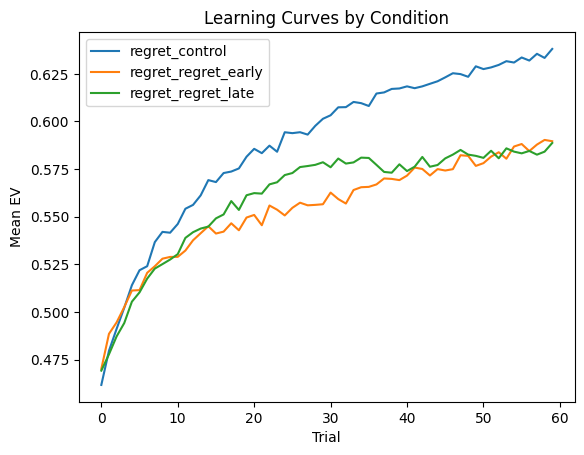

In [191]:

df_all['choice_goodbad'] = df_all['choice_goodbad'].replace({'worst': 0.2, 'medium': 0.5, 'best': 0.7})

grouped = df_all.groupby(['condition','trial_index'])['choice_goodbad'].mean().reset_index() 
for cond in grouped['condition'].unique():
    subset = grouped[grouped['condition'] == cond]
    plt.plot(subset['trial_index'], subset['choice_goodbad'], label=cond) 


plt.xlabel('Trial')
plt.ylabel('Mean EV')
plt.title('Learning Curves by Condition')
plt.legend()
plt.show()

## Null

In [200]:

num_trees = 3
num_trials = 60  
tree_probs = [0.7, 0.5, 0.2]  

tree_probabilities = {i: prob for i, prob in enumerate(tree_probs)}

sorted_trees = sorted(tree_probabilities, key=tree_probabilities.get, reverse=True)
best_tree = sorted_trees[0]    # index of the best tree
medium_tree = sorted_trees[1]  # index of the medium tree
worst_tree = sorted_trees[2]   # index of the worst tree

all_data = []

# -----------------------
# Loop over each participant
# -----------------------
for idx, row in participants_df.iterrows():
    
    participant_id = row['participant']
    condition = row['condition']    
    eta = row['mean_eta']  # learning rate for the chosen tree
    #eta = 0.2
    
    num_simulations = 100
    
    for sim_id in range(num_simulations):
        tree_beliefs = np.ones(num_trees) / num_trees  # initial beliefs
        alpha = np.ones(num_trees) * 1  # prior alpha for Beta distribution
        beta = np.ones(num_trees) * 1 # prior beta for Beta distribution
        points = np.zeros(num_trials)
        
        # Run RL agent for the specified number of trials
        # for trial in range(num_trials):
        #     exp_values = np.exp(tree_beliefs / temperature)
        #     softmax_values = exp_values / np.sum(exp_values)
            
        #     # Select action based on the softmax probabilities
        #     action = np.random.choice(np.arange(num_trees), p=softmax_values)

        for trial in range(num_trials):
            sampled_values = [
                np.random.beta(alpha[a], beta[a]) for a in range(num_trees)
            ]
            action = np.argmax(sampled_values)
            
            # Simulate outcome of the chosen tree
            outcome = np.random.choice([0, 1], p=[1 - tree_probs[action], tree_probs[action]])
            points[trial] = outcome
            
            # Update alpha/beta for the chosen tree based on the actual outcome
            if outcome == 1:
                alpha[action] += 1 * eta
            else:
                beta[action] += 1 * eta
            
            for tree in range(num_trees):
                successes = alpha[tree]
                failures = beta[tree]
                tree_beliefs[tree] = successes / (successes + failures)
            
            if action == best_tree:
                choice_goodbad = 'best'
            elif action == medium_tree:
                choice_goodbad = 'medium'
            else:
                choice_goodbad = 'worst'
            
            all_data.append({
                'participant': participant_id,
                'eta': row['mean_eta'],
                'omega': row['omega'],
                'trial_index': trial,
                'points': points[trial],
                'choice_goodbad': choice_goodbad,
                'condition': condition  
            })
# -----------------------
# Convert to DataFrame and Save
# -----------------------
df_all = pd.DataFrame(all_data)

df_all = df_all[['participant', 'eta', 'omega', 'trial_index',
                 'points', 'choice_goodbad', 'condition']]

#df_all.to_csv('../data/simulation_output_all_participants_null.csv', index=False)
df_all.to_csv('../data/null_simulation_thompson_eta.csv', index=False)

## CS

In [ ]:

participants_df = pd.read_csv('../data/cs_mcmc_eta.csv')

participants_df['omega'] = participants_df.apply(lambda row: 0 if row['condition'] == 'control' else row['mean_omega'], axis=1)

participants_df = participants_df[participants_df['participant'] != 797]
participants_df = participants_df[participants_df['participant'] != 881]

participants_df.head()

,participant,condition,mean_omega,median_omega,mean_eta,median_eta,omega
0,860,regret_late,1.476622,1.201344,0.273687,0.264847,1.476622
1,835,regret_late,0.011669,0.007092,0.711152,0.699559,0.011669
2,753,regret_late,0.004863,0.004208,0.461364,0.449788,0.004863
3,833,regret_late,0.879187,0.551897,0.210519,0.215474,0.879187
4,841,regret_late,0.013469,0.007073,0.311125,0.265944,0.013469


In [208]:

num_trees = 3
num_trials = 60
tree_probs = [0.7, 0.5, 0.2] 

tree_probabilities = {i: prob for i, prob in enumerate(tree_probs)}

sorted_trees = sorted(tree_probabilities, key=tree_probabilities.get, reverse=True)
best_tree = sorted_trees[0]    # index of the best tree
medium_tree = sorted_trees[1]  # index of the medium tree
worst_tree = sorted_trees[2]   # index of the worst tree

all_data = []

early_trigger_count = 0
late_trigger_count = 0

# -----------------------
# Loop over each participant
# -----------------------
for idx, row in participants_df.iterrows():
    
    participant_id = row['participant']
    counterfactual_weight = row['omega']
    condition = row['condition']       
    eta = row['mean_eta']  # learning rate for the chosen tree
    #eta = 0.5
    
    num_simulations = 100
    
    for sim_id in range(num_simulations):
        tree_beliefs = np.ones(num_trees) / num_trees  # initial beliefs
        alpha = np.ones(num_trees) * 1  # prior alpha for Beta distribution
        beta = np.ones(num_trees) * 1  # prior beta for Beta distribution
        points = np.zeros(num_trials)
        
        # Run RL agent for the specified number of trials
        # for trial in range(num_trials):
        #     exp_values = np.exp(tree_beliefs / temperature)
        #     softmax_values = exp_values / np.sum(exp_values)
            
        #     # Select action based on softmax probabilities
        #     action = np.random.choice(np.arange(num_trees), p=softmax_values)

        for trial in range(num_trials):
            sampled_values = [
                np.random.beta(alpha[a], beta[a]) for a in range(num_trees)
            ]
            action = np.argmax(sampled_values)
            
            # Simulate outcome of the chosen tree
            outcome = np.random.choice([0, 1], p=[1 - tree_probs[action], tree_probs[action]])
            points[trial] = outcome
            
            # CS updating
            if condition == "regret_early" and trial <= 30 and outcome == 0:
                early_trigger_count += 1
                for tree in range(num_trees):
                    if tree != action:
                        # Initialize a counterfactual outcome vector and simulate for this tree based on beliefs
                        counterfactual_outcome = np.zeros(num_trees)
                        counterfactual_outcome[tree] = np.random.choice(
                            [0, 1], p=[1 - tree_beliefs[tree], tree_beliefs[tree]]
                        )
                        if counterfactual_outcome[tree] == 1:
                            alpha[tree] += counterfactual_weight 
                        else:
                            beta[tree] += counterfactual_weight 

            if condition == "regret_late" and trial > 30 and outcome == 0:
                late_trigger_count += 1
                for tree in range(num_trees):
                    if tree != action:
                        # Initialize a counterfactual outcome vector and simulate for this tree based on beliefs
                        counterfactual_outcome = np.zeros(num_trees)
                        counterfactual_outcome[tree] = np.random.choice(
                            [0, 1], p=[1 - tree_beliefs[tree], tree_beliefs[tree]]
                        )
                        if counterfactual_outcome[tree] == 1:
                            alpha[tree] += counterfactual_weight 
                        else:
                            beta[tree] += counterfactual_weight 

            # Update alpha/beta for the chosen tree based on the actual outcome
            if outcome == 1:
                alpha[action] += 1 * eta
            else:
                beta[action] += 1 * eta

            for tree in range(num_trees):
                successes = alpha[tree]
                failures = beta[tree]
                tree_beliefs[tree] = successes / (successes + failures)
            
            if action == best_tree:
                choice_goodbad = 'best'
            elif action == medium_tree:
                choice_goodbad = 'medium'
            else:
                choice_goodbad = 'worst'
            
            all_data.append({
                'participant': participant_id,
                'omega': row['omega'],
                'eta': row['mean_eta'],
                'trial_index': trial,
                'points': points[trial],
                'choice_goodbad': choice_goodbad,
                'condition': f'regret_{condition}'
            })

# -----------------------
# Convert to DataFrame and Save
# -----------------------
df_all = pd.DataFrame(all_data)

df_all = df_all[['participant', 'eta', 'omega', 'trial_index',
                 'points', 'choice_goodbad', 'condition']]

df_all.to_csv('../data/cf_simulation_thompson_eta.csv', index=False)

/var/folders/hx/nvry4lc559vbztjv2c_4m84r0000gn/T/ipykernel_75850/3419960886.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_all['choice_goodbad'] = df_all['choice_goodbad'].replace({'worst': 0.2, 'medium': 0.5, 'best': 0.7})


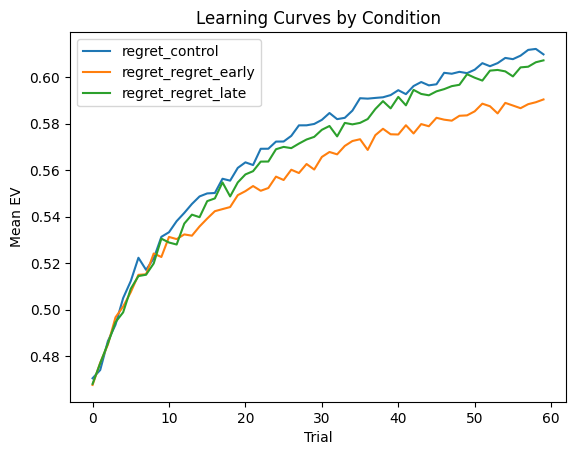

In [197]:

df_all['choice_goodbad'] = df_all['choice_goodbad'].replace({'worst': 0.2, 'medium': 0.5, 'best': 0.7})

grouped = df_all.groupby(['condition','trial_index'])['choice_goodbad'].mean().reset_index() 
for cond in grouped['condition'].unique():
    subset = grouped[grouped['condition'] == cond]
    plt.plot(subset['trial_index'], subset['choice_goodbad'], label=cond) 


plt.xlabel('Trial')
plt.ylabel('Mean EV')
plt.title('Learning Curves by Condition')
plt.legend()
plt.show()

# Theroretical simulation

In [ ]:

# Set up parameters
num_trees = 3
num_trials = 60 
tree_probs = [0.7, 0.5, 0.2] 

tree_probabilities = {i: prob for i, prob in enumerate(tree_probs)}
sorted_trees = sorted(tree_probabilities, key=tree_probabilities.get, reverse=True)
best_tree = sorted_trees[0]
medium_tree = sorted_trees[1]
worst_tree = sorted_trees[2]

omega_values = [0.1, 0.5, 1]  # Fixed omega values
num_simulations = 100
eta = 1  # Learning rate fixed

all_data = []

# -----------------------
# 1. GiG Model Simulation
# -----------------------
for omega in omega_values:
    for idx, row in participants_df.iterrows():
        participant_id = row['participant']
        condition = row['condition']

        for sim_id in range(num_simulations):
            tree_beliefs = np.ones(num_trees) / num_trees
            alpha = np.ones(num_trees) * 1
            beta = np.ones(num_trees) * 1

            for trial in range(num_trials):
                sampled_values = [np.random.beta(alpha[a], beta[a]) for a in range(num_trees)]
                action = np.argmax(sampled_values)

                outcome = np.random.choice([0, 1], p=[1 - tree_probs[action], tree_probs[action]])

                # GiG regret updating
                if (condition == 'regret_early' and trial <= 30) or (condition == 'regret_late' and trial > 30):
                    if outcome == 0:
                        for tree in range(num_trees):
                            if tree != action:
                                alpha[tree] += omega  

                # Standard outcome updating
                if outcome == 1:
                    alpha[action] += 1 * eta
                else:
                    beta[action] += 1 * eta

                for tree in range(num_trees):
                    tree_beliefs[tree] = alpha[tree] / (alpha[tree] + beta[tree])

                choice_goodbad = ('best' if action == best_tree else
                                  'medium' if action == medium_tree else
                                  'worst')

                all_data.append({
                    'participant': participant_id,
                    'model': 'GiG',     
                    'omega': omega,
                    'trial_index': trial,
                    'points': outcome,
                    'choice_goodbad': choice_goodbad,
                    'condition': f'regret_{condition}'
                })

# -----------------------
# 2. CS Model Simulation
# -----------------------
for omega in omega_values:
    for idx, row in participants_df.iterrows():
        participant_id = row['participant']
        condition = row['condition']

        for sim_id in range(num_simulations):
            tree_beliefs = np.ones(num_trees) / num_trees
            alpha = np.ones(num_trees) * 1
            beta = np.ones(num_trees) * 1

            for trial in range(num_trials):
                sampled_values = [np.random.beta(alpha[a], beta[a]) for a in range(num_trees)]
                action = np.argmax(sampled_values)

                outcome = np.random.choice([0, 1], p=[1 - tree_probs[action], tree_probs[action]])

                # CS updating
                if condition == "regret_early" and trial <= 30 and outcome == 0:
                    early_trigger_count += 1
                    for tree in range(num_trees):
                        if tree != action:
                            counterfactual_outcome = np.zeros(num_trees)
                            counterfactual_outcome[tree] = np.random.choice(
                                [0, 1], p=[1 - tree_beliefs[tree], tree_beliefs[tree]]
                            )
                            if counterfactual_outcome[tree] == 1:
                                alpha[tree] += omega
                            else:
                                beta[tree] += omega 

                elif condition == "regret_late" and trial > 30 and outcome == 0:
                    late_trigger_count += 1
                    for tree in range(num_trees):
                        if tree != action:
                            counterfactual_outcome = np.zeros(num_trees)
                            counterfactual_outcome[tree] = np.random.choice(
                                [0, 1], p=[1 - tree_beliefs[tree], tree_beliefs[tree]]
                            )
                            if counterfactual_outcome[tree] == 1:
                                alpha[tree] += omega 
                            else:
                                beta[tree] += omega

                # Standard outcome updating
                if outcome == 1:
                    alpha[action] += 1 * eta
                else:
                    beta[action] += 1 * eta

                for tree in range(num_trees):
                    tree_beliefs[tree] = alpha[tree] / (alpha[tree] + beta[tree])

                choice_goodbad = ('best' if action == best_tree else
                                  'medium' if action == medium_tree else
                                  'worst')

                all_data.append({
                    'participant': participant_id,
                    'model': 'CS',    
                    'omega': omega,
                    'trial_index': trial,
                    'points': outcome,
                    'choice_goodbad': choice_goodbad,
                    'condition': f'regret_{condition}'
                })

# -----------------------
# 3. Null Model Simulation 
# -----------------------
for idx, row in participants_df.iterrows():
    participant_id = row['participant']
    condition = row['condition']

    for sim_id in range(num_simulations):
        tree_beliefs = np.ones(num_trees) / num_trees
        alpha = np.ones(num_trees) * 1
        beta = np.ones(num_trees) * 1

        for trial in range(num_trials):
            sampled_values = [np.random.beta(alpha[a], beta[a]) for a in range(num_trees)]
            action = np.argmax(sampled_values)

            outcome = np.random.choice([0, 1], p=[1 - tree_probs[action], tree_probs[action]])

            if outcome == 1:
                alpha[action] += 1 * eta
            else:
                beta[action] += 1 * eta

            for tree in range(num_trees):
                tree_beliefs[tree] = alpha[tree] / (alpha[tree] + beta[tree])

            choice_goodbad = ('best' if action == best_tree else
                              'medium' if action == medium_tree else
                              'worst')

            all_data.append({
                'participant': participant_id,
                'model': 'Null',      
                'omega': 0.0,         
                'trial_index': trial,
                'points': outcome,
                'choice_goodbad': choice_goodbad,
                'condition': f'regret_{condition}'
            })

# -----------------------
# Output
# -----------------------
df_all = pd.DataFrame(all_data)

df_all = df_all[['participant', 'model', 'omega', 'trial_index',
                 'points', 'choice_goodbad', 'condition']]

df_all.to_csv('../data/combined_simulation_thompson.csv', index=False)